In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/prichter/Documents/selenobot/src/')

# Detection task

"Detection task" refers to the ability of the classifier to identify a sequence as either an erroneously-truncated selenoprotein, or a full-length non-selenoprotein. For this task, we used full-length negative normal proteins as negative test cases. The negative cases did *not* include full-length selenoproteins; we are basing this project on the observation that selenoproteins are misidentified, so full-length selenoproteins will not be present in the data we use to validate the model. The positive cases consisted of selenoproteins truncated at the *first* selenocysteine residue only. 

In [3]:
# Define the data and figure directories. 
DATA_DIR = '/home/prichter/Documents/selenobot/data/uniprot_2023_03/detect' 
FIGURE_DIR = '/home/prichter/Documents/selenobot/figures/'

In [4]:
from src.classifiers import EmbeddingClassifier, AacClassifier, optimize_hyperparameters
from src.dataset import get_dataloader
from src.utils import csv_ids, csv_labels
import src.plot as plot

import os
import matplotlib.pyplot as plt
import seaborn as sns

/home/prichter/Documents/selenobot/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Paths where the train and test data are stored. 
train_path = os.path.join(DATA_DIR, 'train.csv')
test_path = os.path.join(DATA_DIR, 'test.csv')
val_path = os.path.join(DATA_DIR, 'val.csv')

# First load the data into a dataset object. 
train_dataloader = get_dataloader(train_path, batch_size=2048)
val_dataloader = get_dataloader(val_path, batch_size=2048)
# test_dataloader = get_dataloader(test_path, batch_size=1024)

## Testing the benchmark

In [ ]:
# First, try training with no other weight, to get a sense of how many epochs to use.
model = EmbeddingClassifier(latent_dim=1024) 
# model = EmbeddingClassifier(1024)

In [ ]:
# aac_reporters = []
# for bce_loss_weight in [1, 10, 100, 1000, 10000, 100000]:
#     model.reset() # Reset the model weights. 
#     aac_reporter = model._train(train_dataloader, val=test_dataloader, epochs=1, lr=0.001, bce_loss_weight=bce_loss_weight)
#     aac_reporters.append(aac_reporter)
#     break
reporter = model.fit(train_dataloader, val=val_dataloader, epochs=15, lr=0.001, bce_loss_weight=1) 

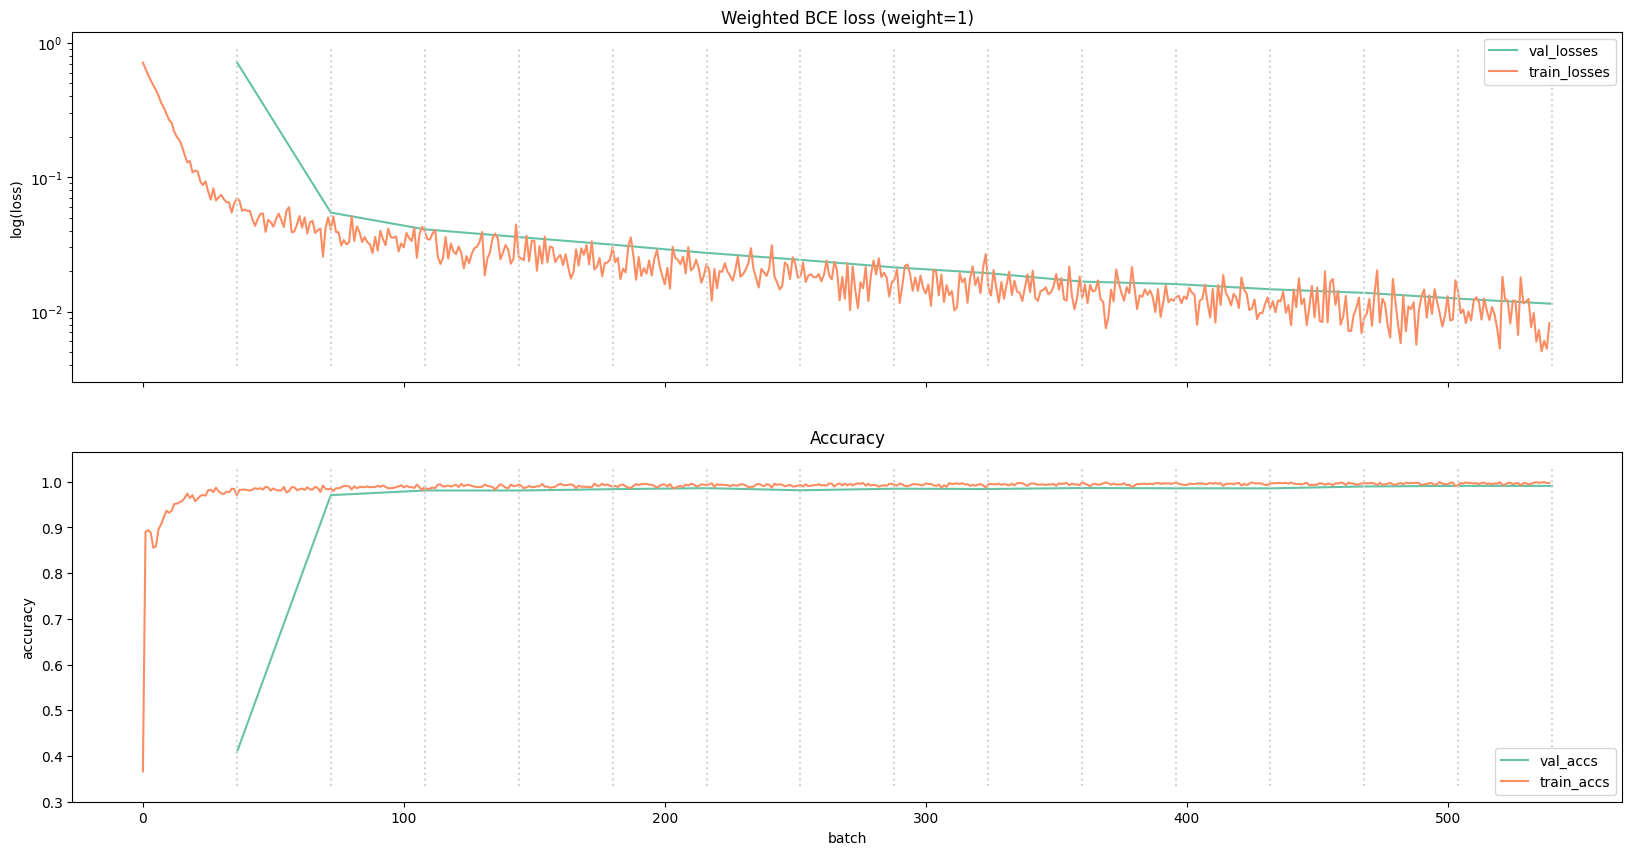

In [ ]:
plot.plot_model_training(reporter, path=None)

In [ ]:
best = optimize_hyperparameters(train_dataloader, val_dataloader, model=EmbeddingClassifier(), n_calls=50)

classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=91087.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=216758.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=858934.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=563892.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.56 with bce_loss_weight=42579.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=330291.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=948380.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=287644.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=114731.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=612423.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=999985.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=858934.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=82499.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.55 with bce_loss_weight=95470.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858934.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858934.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=214877.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=858934.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=847449.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=870744.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=228672.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=199552.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=733235.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=858952.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=447335.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=672707.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=793384.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858991.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=388932.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=505704.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.55 with bce_loss_weight=898633.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.96 with bce_loss_weight=52.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858961.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858942.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=858939.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.9 with bce_loss_weight=151.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=862734.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=157460.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=824909.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=256483.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=642660.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=855039.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.55 with bce_loss_weight=90666.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=859474.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=702810.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=763491.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=418012.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=857231.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=217258.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=217487.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=217259.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=999951.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=217127.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=476518.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=861329.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=217015.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=857400.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=860361.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=360015.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=360011.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=357865.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=360914.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=361723.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=366167.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=352895.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=357618.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=359624.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.54 with bce_loss_weight=359597.


classifiers.optimize_hyperparameters: Recorded a test accuracy of 0.08 with bce_loss_weight=359662.


classifiers.Classifier.train_: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

In [ ]:
best = optimize_hyperparameters(train_dataloader, val_dataloader, model=AacClassifier(), n_calls=50)

classifiers.optimize_hyperparameters: Recorded a test loss of 25.54 with bce_loss_weight=3472.


classifiers.optimize_hyperparameters: Recorded a test loss of 9.64 with bce_loss_weight=6590.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.85 with bce_loss_weight=7201.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.99 with bce_loss_weight=4932.


classifiers.optimize_hyperparameters: Recorded a test loss of 7.45 with bce_loss_weight=8862.


classifiers.optimize_hyperparameters: Recorded a test loss of 5.57 with bce_loss_weight=1185.


classifiers.optimize_hyperparameters: Recorded a test loss of 5.98 with bce_loss_weight=2060.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.71 with bce_loss_weight=4777.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.57 with bce_loss_weight=4558.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.38 with bce_loss_weight=4006.


classifiers.optimize_hyperparameters: Recorded a test loss of 5.29 with bce_loss_weight=1277.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.85 with bce_loss_weight=7976.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.89 with bce_loss_weight=211.


classifiers.optimize_hyperparameters: Recorded a test loss of 4.46 with bce_loss_weight=540.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.7 with bce_loss_weight=242.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.7 with bce_loss_weight=261.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.76 with bce_loss_weight=278.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.62 with bce_loss_weight=252.


classifiers.optimize_hyperparameters: Recorded a test loss of 5.72 with bce_loss_weight=4211.


classifiers.optimize_hyperparameters: Recorded a test loss of 5.32 with bce_loss_weight=1646.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.85 with bce_loss_weight=10000.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.87 with bce_loss_weight=9464.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.39 with bce_loss_weight=5681.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.87 with bce_loss_weight=331.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.11 with bce_loss_weight=7579.


classifiers.optimize_hyperparameters: Recorded a test loss of 4.57 with bce_loss_weight=781.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.42 with bce_loss_weight=8417.


classifiers.optimize_hyperparameters: Recorded a test loss of 6.45 with bce_loss_weight=6027.


classifiers.optimize_hyperparameters: Recorded a test loss of 3.0 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.75 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.27 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.26 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.


classifiers.optimize_hyperparameters: Recorded a test loss of 0.25 with bce_loss_weight=1.
